### Step 1. Open the data

In the first step I will get a general view of the videogame data source and any glaring issues with data-types or missing information.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from scipy import stats as st

try:
    df = pd.read_csv('../datasets/games.csv')
except:
    df = pd.read_csv('/datasets/games.csv','\t')

df.sample(5)
# columns need to be lowercase

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
6810,Homefront,PC,2011.0,Shooter,0.11,0.10,0.00,0.03,70.0,5.5,M
5440,Beyond Good & Evil,PS2,2003.0,Adventure,0.16,0.13,0.00,0.04,NaN,NaN,NaN
134,Halo 3: ODST,X360,2009.0,Shooter,4.34,1.34,0.06,0.61,83.0,7.1,M
4398,World Stadium EX,PS,1996.0,Sports,0.00,0.00,0.41,0.03,NaN,NaN,NaN
4491,Naughty Bear,PS3,2010.0,Action,0.18,0.18,0.00,0.07,43.0,5.5,T


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


16715 entries of videogame data, sales information from various regions, user and critic scores, etc.

## Step 2. Data preprocessing

In [22]:
# column names converted to lowercase
df.columns= df.columns.str.lower()

# look for null values
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

- two missing entries in `name` can't be recovered because there isn't enough information, will be ignored.
- `year_of_release` can be approximated based on the median year for platform it's released on because platforms have about a ~9 year lifecycle for releases.
- `genre` can be added simply by looking at the two titles
- missing `rating` can be added by looking at the `genre`
- `critic_score` and `user_score` could be approximated if one exists and the other doesn't by median ratio of user to critic rating and vice-versa. (Otherwise will use the median score by platform.

#### `year_of_release`

In [23]:
# find median release year per platform
median_year_by_platform = df.pivot_table(index='platform',values='year_of_release',aggfunc='median')

# for missing year release values, approximate based on median year based on platform
def fill_year(row):
    if math.isnan(row['year_of_release']):
        platform = row['platform']
        return median_year_by_platform.query('platform == @platform')['year_of_release'][0]
    else:
        return row['year_of_release']

df['year_of_release'] = df.apply(fill_year,axis=1)
print("Nulls in year_of_release: ",df['year_of_release'].isnull().sum())

Nulls in year_of_release:  0


#### `genre`

In [24]:
df.loc[df['genre'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


The two missing values in `name` also have missing `genre` so they will be ignored. In a later step, it became apparent that some user score were set to 'tbd' so I will first replace those with `NaN` in order to properly calculate medians later on. I will also convert the `user_score` to a float for calculations.

#### Convert Data Types

In [25]:
df['user_score'] = df['user_score'].replace('tbd','NaN')
# some user_scores are set to tbd, could be because no/not enough user reviews or game not released yet

try:
    df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y').dt.year
    df['user_score'] = df['user_score'].astype(float)
    df.info()
except:
    print('Error converting')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


#### `all_sales`

In [26]:
# add all_sales column
df['all_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales'] 
df['all_sales'].describe()

count    16715.000000
mean         0.533396
std          1.548261
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: all_sales, dtype: float64

In [27]:
# remove outlier rows with the sales data (outlier was very apparent by max in all_sales)
min_sales = df['all_sales'].quantile(0.01)
max_sales = df['all_sales'].quantile(0.99)

df = df.query("@min_sales < all_sales < @max_sales")
maximum = df['all_sales'].max()
print("The new maximum without sales outliers is: {:.2f}".format(maximum))

The new maximum without sales outliers is: 5.45


#### `rating`

In [28]:
df['rating'].value_counts()

E       3796
T       2840
M       1466
E10+    1373
EC         8
K-A        2
RP         2
AO         1
Name: rating, dtype: int64

- There aren't enough AO, EC (Early Childhood) titles to analyze- simply drop.
- RP means rating pending but we can approximate individually for those 2 titles.
- K-A (kids to adults) can be grouped with E

In [29]:
df.query('rating == "RP"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
13672,Clockwork Empires,PC,2010,Strategy,0.0,0.04,0.0,0.00,58.0,3.8,RP,0.04
14270,Supreme Ruler: Cold War,PC,2011,Strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP,0.04


In [30]:
# generally strategy game of this type are T
df['rating'].replace('RP','T',inplace=True)

df['rating'].replace('K-A','E',inplace=True)
df = df.query('rating != "AO" and rating != "EC"')
df['rating'].value_counts()

E       3798
T       2842
M       1466
E10+    1373
Name: rating, dtype: int64

In [31]:
# encode the rating column
def rating_id(row):
    if row['rating'] == "E":
        return 0
    elif row['rating'] == "E10+":
        return 1
    elif row['rating'] == "T":
        return 2
    elif row['rating'] == "M":
        return 3
    else:
        return np.nan
df['rating_id'] = df.apply(rating_id,axis=1)

# now use pivot table on genre to find median rating
median_rating_by_genre = df.pivot_table(index='genre',values='rating_id',aggfunc='median')
median_rating_by_genre

,rating_id
genre,
Action,2.0
Adventure,1.0
Fighting,2.0
Misc,0.0
Platform,0.0
Puzzle,0.0
Racing,0.0
Role-Playing,2.0
Shooter,3.0


In [32]:
# slice out the 2 null genre rows (also the null name rows)
df = df.query('genre == genre')

def fill_rating_id(row):
    if math.isnan(row['rating_id']):
        genre = row['genre']
        return median_rating_by_genre.query('genre == @genre')['rating_id'][0]
    else:
        return row['rating_id']
df['rating_id'] = df.apply(fill_rating_id,axis=1)

#then fill missing rating strings (for later analysis)
def id_to_string(rating_id):
    if rating_id == 0:
        return 'E'
    elif rating_id == 1:
        return 'E10+'
    elif rating_id == 2:
        return 'T'
    elif rating_id == 3:
        return 'M'
    else:
        return ''

def fill_rating(row):
    rating_id = row['rating_id']
    return id_to_string(rating_id)
df['rating'] = df.apply(fill_rating,axis=1)

print("Rating_id nulls: ",df['rating_id'].isna().sum())
print("Rating nulls: ",df['rating'].isna().sum())

Rating_id nulls:  0
Rating nulls:  0


#### `user_score` & `critic_score`

In [33]:
# first take a look at correlation table to gather 
corr = df['user_score'].corr(df['critic_score'])
print('The correlation between user_score and critic_score = {:2f}'.format(corr))

The correlation between user_score and critic_score = 0.581025


There is a correlation between the `critic_score` and `user_score` (both are gamers with opinions) however both of those columns are missing values. So I will fill in the null scores if the other score exists.

In [34]:
# First use present user ratings to approximate
median_critic_user_ratio = df['critic_score'].median()/df['user_score'].median()
# then use sales to approximate
median_critic_sales_ratio = df['critic_score'].median()/df['all_sales'].median()
max_user_score = df['user_score'].max()

# there are more user score missing so I will approximate them with the critic scores
def missing_user(row):
    if math.isnan(row['user_score']) and not math.isnan(row['critic_score']):
        return min(row['critic_score']/median_critic_user_ratio,max_user_score)
    else:
        return row['user_score']
df['user_score'] = df.apply(missing_user,axis=1)

# then fill missing critic scores with existing user scores
def missing_critic(row):
    if math.isnan(row['critic_score']) and not math.isnan(row['user_score']):
        return row['user_score']*median_critic_user_ratio
    else:
        return row['critic_score']

df['critic_score'] = df.apply(missing_critic,axis=1)
print("Critic score nulls: ",df['critic_score'].isna().sum())
print("User score nulls: ",df['user_score'].isna().sum())

Critic score nulls:  7423
User score nulls:  7423


In [35]:
# now use median scores by platform to approximate remaining missing values
platform_to_mean = df.groupby('platform')['critic_score'].mean().to_dict()

# approximate the critic scores by mean score of platform
def filler(row):
    if np.isnan(row['critic_score']):
        return platform_to_mean.get(row['platform'])
    return row['critic_score']
df['critic_score'] = df.apply(filler, axis=1)

# then reapply approximation of user_score with critic scores
df['user_score'] = df.apply(missing_user,axis=1)
print("Critic score nulls: ",df['critic_score'].isna().sum())
print("User score nulls: ",df['user_score'].isna().sum())

Critic score nulls:  1090
User score nulls:  1090


In [36]:
# find more information about still missing rows (likely older games when scores and game critics weren't as common)
missing = df.loc[df['critic_score'].isna()]
missing.pivot_table(index='year_of_release',values='name',aggfunc='count')

,name
year_of_release,
1980,9
1981,46
1982,52
1983,17
1984,13
1985,11
1986,20
1987,16
1988,11


#### Nulls/duplicates

In [37]:
df[df.duplicated() == True].count()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
all_sales          0
rating_id          0
dtype: int64

In [38]:
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       1090
user_score         1090
rating                0
all_sales             0
rating_id             0
dtype: int64

In [39]:
# rows with missing scores are all before 2003 while analysis isn't pertinent in those years
# also drop possible duplicates
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14647 entries, 169 to 16289
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             14647 non-null  object 
 1   platform         14647 non-null  object 
 2   year_of_release  14647 non-null  int64  
 3   genre            14647 non-null  object 
 4   na_sales         14647 non-null  float64
 5   eu_sales         14647 non-null  float64
 6   jp_sales         14647 non-null  float64
 7   other_sales      14647 non-null  float64
 8   critic_score     14647 non-null  float64
 9   user_score       14647 non-null  float64
 10  rating           14647 non-null  object 
 11  all_sales        14647 non-null  float64
 12  rating_id        14647 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 1.6+ MB


All missing values have been removed. `year_of_release` was converted to an int, wasn't necessary to make it dateTime because month/days aren't relevant. Also having the year as an int lets us see the correlation with other columns. The game score is a linear value for efficient analysis. The sales figures from all the regions have been summed into `all_sales` to make a more general analysis.

### Step 3. Data Analysis

#### Yearly Releases

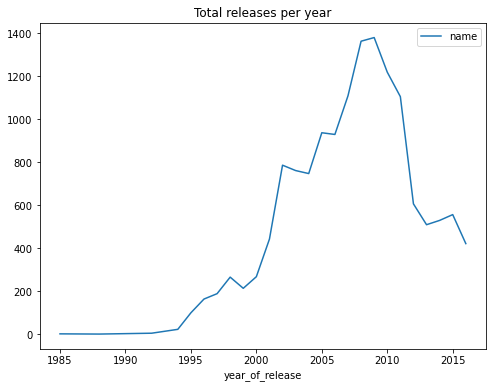

In [40]:
df_yearly_release = df.pivot_table(index='year_of_release',values='name',aggfunc='count')
df_yearly_release.plot(figsize=(8,6))
plt.suptitle("")
plt.title("Total releases per year")
plt.show()

We can see that there was a growing number of game releases until the peak around 2010 and has been in decline.

#### Best-selling Platforms (all-time)

In [41]:
top_platforms = (
    df
    .pivot_table(index='platform',values='all_sales',aggfunc='sum')
    .sort_values('all_sales',ascending=False)
    .head(5)
    .to_dict()['all_sales']
)

print("All-time top-selling platforms:")
for platform in top_platforms:
    print(platform)

All-time top-selling platforms:
PS2
PS3
X360
PS
DS


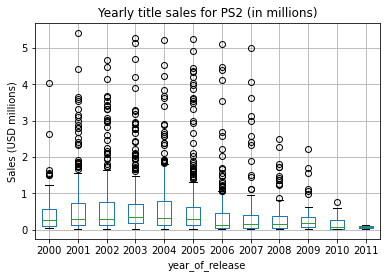

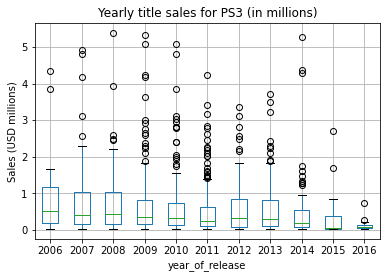

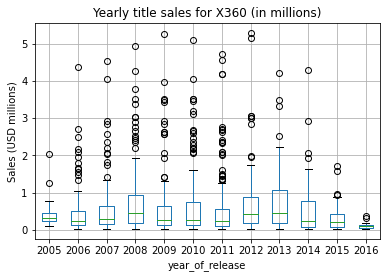

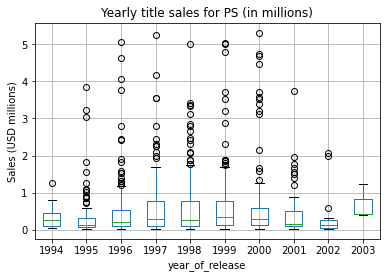

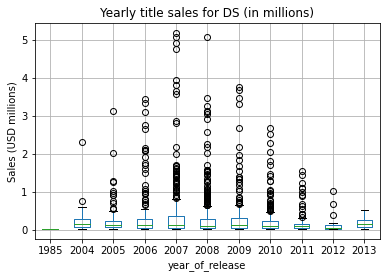

In [42]:
for platform in top_platforms:
    df.query('platform == @platform').boxplot(column='all_sales',by='year_of_release')
    plt.suptitle("")
    plt.ylabel('Sales (USD millions)')
    plt.title("Yearly title sales for "+platform+" (in millions)")
    plt.show()

By the graphs above it looks like the typical lifespan for a platform's popularity/sales is about 10 years. It follows that more videogame producers will want to release games on more established platforms until it's popularity declines.

In [43]:
# apparent outlier in year_of_release for a DS game, must be entry mistake because the DS didn't release until 2004
df.query('platform == "DS" and year_of_release < 2004')
# this row doesn't influence any further analysis so will be ignored - possible future question for data collection/entry

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,rating_id
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,63.692973,6.728131,T,0.02,2.0


For further analysis, I will focus on 2015 & 2016 because it is the most recent data. The previous years indicate a significant peak in sales that doesn't exist now.

### Best-selling Platforms (recent)

In [44]:
current_top_sellers = (
    df
    .query('2015 <= year_of_release <= 2016')
    .pivot_table(index='platform',values='all_sales',aggfunc='sum')
    .sort_values('all_sales',ascending=False)
    .head(5)['all_sales']
    .to_dict()
    .keys()
)

print("Recent top-selling platforms:")
for platform in current_top_sellers:
    print(platform)

Recent top-selling platforms:
PS4
XOne
3DS
WiiU
PS3


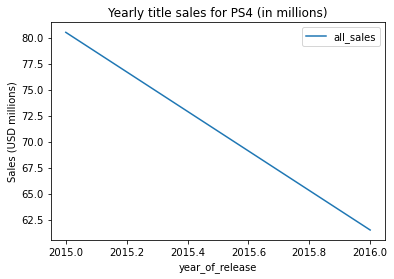

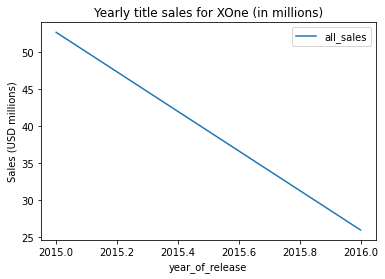

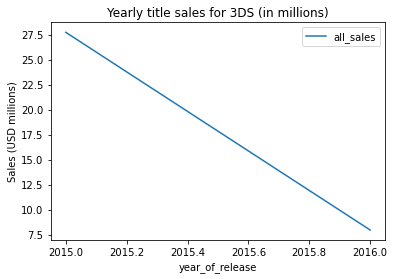

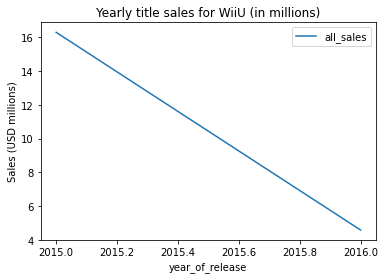

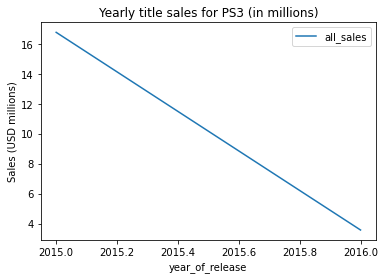

In [45]:
for platform in current_top_sellers:
    (
        df
        .query('platform == @platform and 2015 <= year_of_release <= 2016')
        .pivot_table(index='year_of_release',values='all_sales',aggfunc='sum')
        .plot()
    )
    plt.suptitle("")
    plt.title("Yearly title sales for "+platform+" (in millions)")
    plt.ylabel('Sales (USD millions)')
    plt.show()

df = df.query('2015 <= year_of_release <= 2016')

Comparing 2015 and 2016, we can see that all platforms are shrinking.

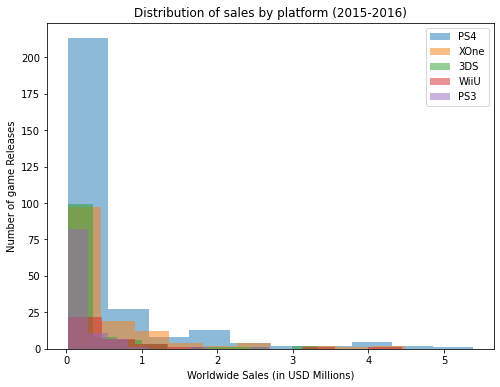

In [46]:
fig, ax = plt.subplots()

for platform in current_top_sellers:
    df_plat = df.query('platform == @platform')
    df_plat['all_sales'].plot(kind="hist",figsize=(8,6),alpha=0.5,ax=ax)

plt.suptitle("")
plt.title("Distribution of sales by platform (2015-2016)")
ax.legend(current_top_sellers)
plt.xlabel("Worldwide Sales (in USD Millions)")
plt.ylabel("Number of game Releases")
plt.show()

By looking at the distributions of the top selling platforms, clearly PS4 dwarfs the other platforms in terms of sales.

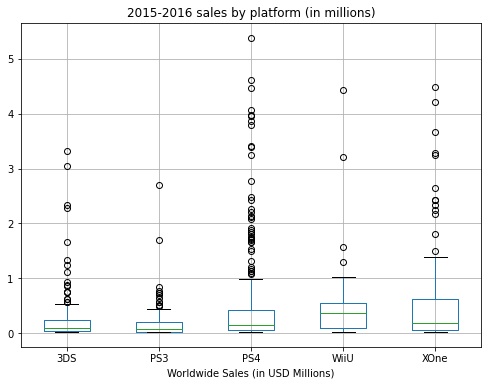

In [47]:
df.query('platform in @current_top_sellers').boxplot(column='all_sales',by='platform',figsize=(8,6))
plt.suptitle("")
plt.title("2015-2016 sales by platform (in millions)")
plt.xlabel("Worldwide Sales (in USD Millions)")
plt.show()

By looking at the boxplots- PS4,Xone and WiiU have similar quartiles/medians (3DS and PS3 are lower) but on PS4 the outliers have the most density and maximimality as the top seller.

#### Sales and Score Correlation

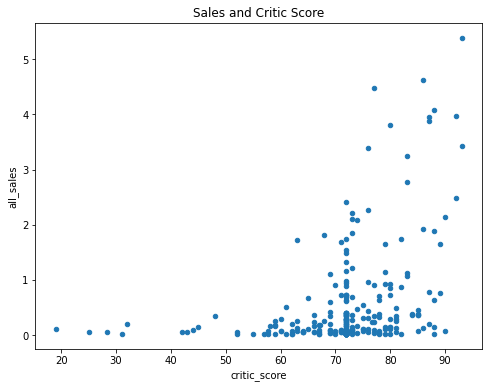

Correlation of world-wide sales and critic score = 0.37855222976467395


In [48]:
df_ps4 = df.query('platform == "PS4"')
df_ps4.plot(x='critic_score', y='all_sales', kind='scatter',figsize=(8,6))
plt.suptitle("")
plt.title("Sales and Critic Score")
plt.show()
corr_ps4_critic_score = df_ps4['critic_score'].corr(df_ps4['all_sales'])
print("Correlation of world-wide sales and critic score = {:}".format(corr_ps4_critic_score))

There is a weak correlation between sales and critic score, consumers will still buy games that aren't loved by critics. While critics can have good opinions, fun and entertainment is subjective.

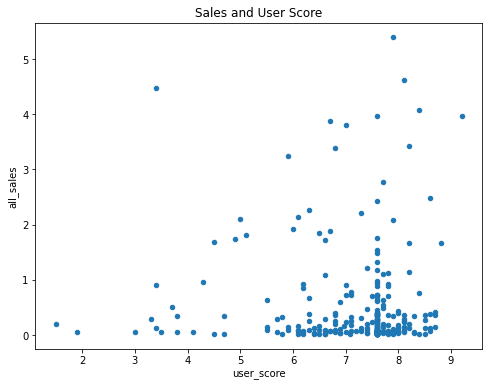

Correlation of world-wide sales and user score = -0.03141873951172319


In [49]:
df_ps4.plot(x='user_score', y='all_sales', kind='scatter',figsize=(8,6))
plt.suptitle("")
plt.title("Sales and User Score")
plt.show()
corr_ps4_user_score = df_ps4['user_score'].corr(df_ps4['all_sales'])
print("Correlation of world-wide sales and user score = {:}".format(corr_ps4_user_score))

There's an even weaker correlation between sales and user score. Gamers will buy games regardless of what other gamers think because tastes are unique.

#### Multiplatform Sales

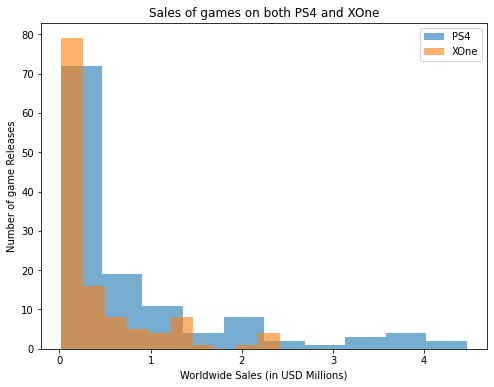

There are 126 games to compare


In [50]:
# compare the top selling platform (PS4 with multiplatform titles released on other platforms)
# look for games released on ps3 and xone
ps4_games = (
    df
    .query('platform == "PS4"')['name']
    .to_dict()
    .values()
)

xone_games = (
    df
    .query('platform == "XOne"')['name']
    .to_dict()
    .values()
)

fig, ax = plt.subplots()
# compare sales of common games for PS4 and XOne
(
    df
    .query('name in @xone_games and name in @ps4_games and (platform == "PS4" or platform == "XOne")')
    .groupby('platform')['all_sales']
    .plot(kind='hist',alpha=0.6,figsize=(8,6),ax=ax)
)
plt.title("Sales of games on both PS4 and XOne")
ax.legend(['PS4','XOne'])
plt.suptitle("")
plt.xlabel("Worldwide Sales (in USD Millions)")
plt.ylabel("Number of game Releases")
plt.show()

num_compare = len(
    df.query('name in @xone_games and name in @ps4_games and (platform == "PS" or platform == "XOne")')['name'].unique()
)
print("There are {:} games to compare".format(num_compare))

The sales of PS4 and XOne games (that exist on both) have a similar distribution, but PS4 has a more apparent maximum and density  of higher sales. This means that given the choice of platform, the same game will sell better on PS4.

In [51]:
ds_games = (
    df
    .query('platform == "DS"')['name']
    .to_dict()
    .values()
)

num_compare = (
    df
    .query('name in @ds_games and name in @ps4_games and (platform == "PS4" or platform == "DS")')['name'].count()
)
print("There are {:} games to compare".format(num_compare))

There are 0 games to compare


There aren't titles to compare the sales of DS and PS4 games.

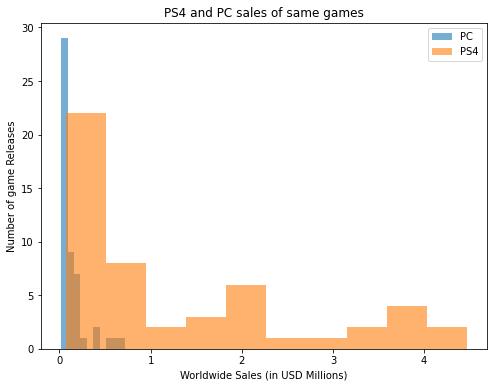

There are 51 games to compare


In [52]:
pc_games = (
    df
    .query('platform == "PC"')['name']
    .to_dict()
    .values()
)
fig, ax = plt.subplots()
# compare sales of common games for PS4 and PC
(
    df
    .query('name in @pc_games and name in @ps4_games and (platform == "PS4" or platform == "PC")')
    .groupby('platform')['all_sales']
    .plot(kind='hist',alpha=0.6,figsize=(8,6), ax=ax)
)
plt.suptitle("")
plt.title("PS4 and PC sales of same games")
plt.xlabel("Worldwide Sales (in USD Millions)")
plt.ylabel("Number of game Releases")
ax.legend(['PC','PS4'])
plt.show()
num_compare = len(df.query('name in @pc_games and name in @ps4_games and (platform == "PS4" or platform == "PC")')['name'].unique())
print("There are {:} games to compare".format(num_compare))

The distributions share a poisson distribution shape but PS4 outsells PC.

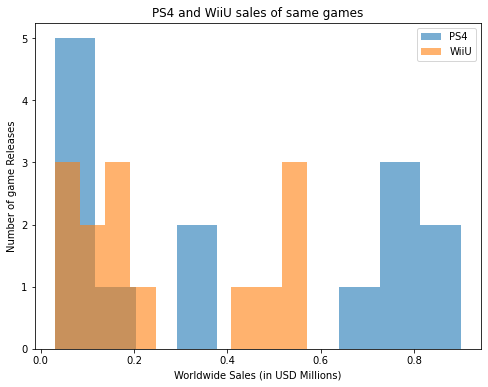

There are 14 games to compare


In [53]:
wiiu_games = (
    df
    .query('platform == "WiiU"')['name']
    .to_dict()
    .values()
)
fig, ax = plt.subplots()
# compare sales of common games for PS4 and WiiU
(
    df
    .query('name in @wiiu_games and name in @ps4_games and (platform == "PS4" or platform == "WiiU")')
    .groupby('platform')['all_sales']
    .plot(kind='hist',alpha=0.6,figsize=(8,6))
)
plt.suptitle("")
plt.title("PS4 and WiiU sales of same games")
plt.xlabel("Worldwide Sales (in USD Millions)")
plt.ylabel("Number of game Releases")
ax.legend(['PS4','WiiU'])
plt.show()
num_compare = len(df.query('name in @wiiu_games and name in @ps4_games and (platform == "PS4" or platform == "WiiU")')['name'].unique())
print("There are {:} games to compare".format(num_compare))

Not enough games to compare distributions.

#### Genre Sales

In [54]:
# first narrow down top genres
top_selling_genres = (
    df
    .pivot_table(index='genre',values='all_sales',aggfunc='sum')
    .sort_values('all_sales',ascending=False)
    .head(5)['all_sales']
    .to_dict()
    .keys()
)
print("List of current top selling genres: {:}".format(top_selling_genres))

List of current top selling genres: dict_keys(['Action', 'Shooter', 'Sports', 'Role-Playing', 'Misc'])


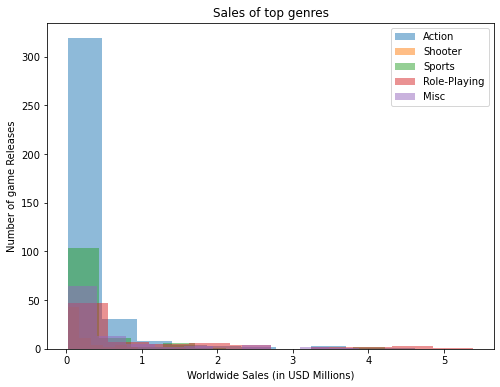

In [55]:
# plot the sales by genre
fig, ax = plt.subplots()
(
    df
    .query('genre in @top_selling_genres')
    .groupby('genre')['all_sales']
    .plot(kind='hist',alpha=0.5,figsize=(8,6),ax=ax)
)
plt.suptitle("")
plt.title("Sales of top genres")
plt.xlabel("Worldwide Sales (in USD Millions)")
plt.ylabel("Number of game Releases")
ax.legend(top_selling_genres)
plt.show()

In [56]:
worst_selling_genres = (
    df
    .pivot_table(index='genre',values='all_sales',aggfunc='sum')
    .sort_values('all_sales',ascending=True)
    .head(5)['all_sales']
    .to_dict()
    .keys()
)
print("List of worst selling genres: {:}".format(worst_selling_genres))

List of worst selling genres: dict_keys(['Puzzle', 'Strategy', 'Simulation', 'Platform', 'Racing'])


The top selling games are more action-packed while the worst selling games are less violent and more 'thinky'.

Game sales have declined in previous years, but the order of most popular companies (Sony,Microsoft,and Nintendo) have stayed consistent (with newer generations of platforms taking over for the older generations). The correlations between critic scores & sales was stronger than the non-existant correlation between user score and critic scores. Consumers are more likely to be influenced than professional opinions. It is also clear that more 'entertaining' video games sell better.

### Step 4. Create a user profile for each region

#### Platform Market Share

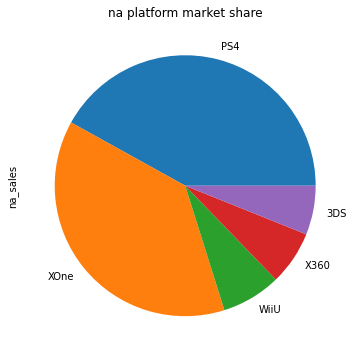

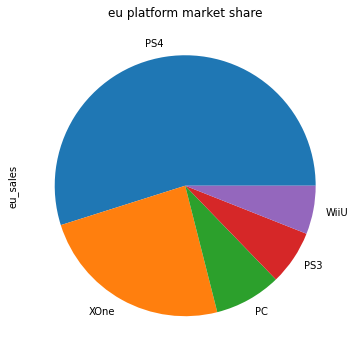

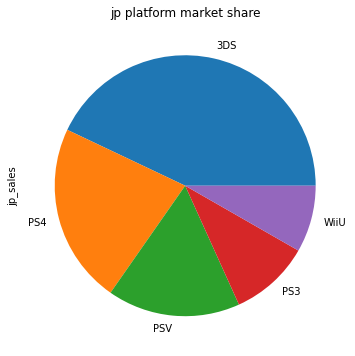

In [57]:
regions = ['na','eu','jp']
for region in regions:
    (
        df
        .pivot_table(index='platform',values=region+'_sales',aggfunc='sum')
        .sort_values(region+'_sales',ascending=False)
        .head(5)[region+'_sales']
        .plot(kind="pie",figsize=(8,6))
    )
    plt.suptitle("")
    plt.title(region+" platform market share")
    plt.show()

XOne has it's best marketshare in America, home of Microsoft. In both America and EU, Nintendo isn't as popular. PSV, PS3,and PS4 take the majority of the Japan market as their producer Sony is Japanese and PSV is in the top 5 (not in other regions). The rest of the market is 3DS and WiiU, produced by Nintendo- another Japanese company.

#### Genre Market Share

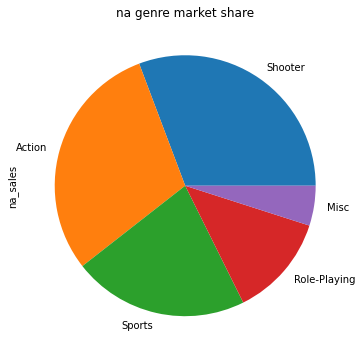

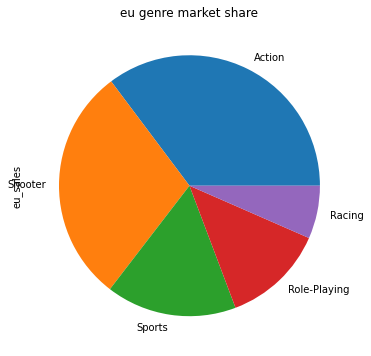

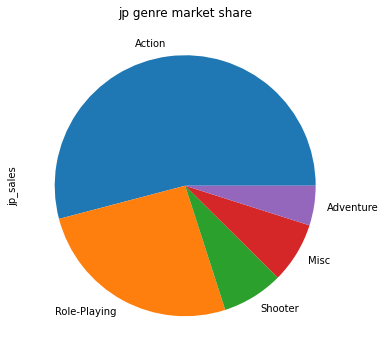

In [58]:
regions = ['na','eu','jp']
for region in regions:
    (
        df
        .pivot_table(index='genre',values=region+'_sales',aggfunc='sum')
        .sort_values(region+'_sales',ascending=False)
        .head(5)[region+'_sales']
        .plot(kind="pie",figsize=(8,6))
    )
    plt.suptitle("")
    plt.title(region+" genre market share")
    plt.show()

The difference in market share, EU and NA prefer pew-pew-shooty games while Japanese have a strong affinity to Role-Playing games, can be explained by the types of games release regionally and cultural differences. There are many Japanese-made RPGs while shooters aren't as popular. 

#### Rating

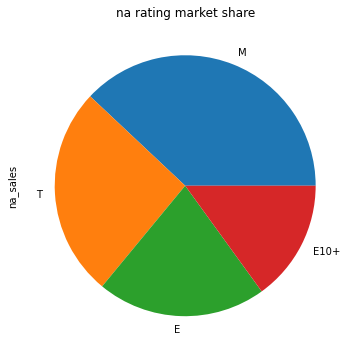

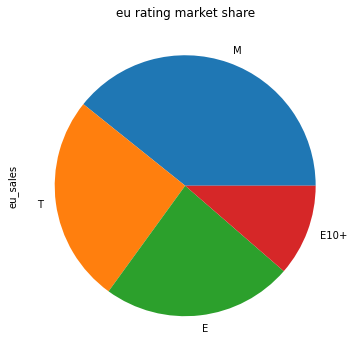

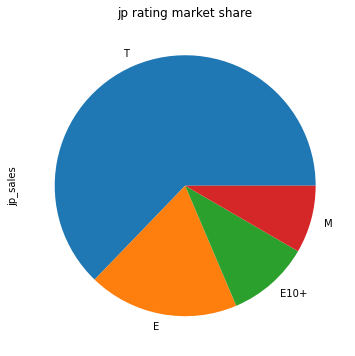

In [59]:
regions = ['na','eu','jp']
for region in regions:
    (
        df
        .pivot_table(index='rating',values=region+'_sales',aggfunc='sum')
        .sort_values(region+'_sales',ascending=False)
        .head(5)[region+'_sales']
        .plot(kind="pie",figsize=(8,6))
    )
    plt.suptitle("")
    plt.title(region+" rating market share")
    plt.show()

It seems like the Japanese market sells mostly T-rated games which makes perfect sense given the popular genres in Japan, action and RPG. Similarly, shooters are far more popular in EU and NA so M-rated games will have a larger marketshare in those regions.

- World-wide Sony platforms have the most market-share.

- The profile for North America looks as such: action-packed and violent games sell better and this is the region where Microsoft has the best chance.

- In the EU the market share of genres/ratings are similar to North America but Sony products have more market share.

- In Japan, the most popular genres and ratings indicate an interest in less violent games. All the popular platforms are domestic products.

## Step 5. Test the hypotheses

We will test the hypotheses in terms of user score between the platforms (Xbox and PC) and genres (Action and Sports). This can show us why certain platforms and genres sell better. We will use an alpha of 5% because it is a significant enough percent. The null hypothesis is that the distribution of the user score data from both platforms/genres are not significantly different. The alternative hypothesis is that there is a statistically significant difference between the distributions of the platforms & genres. The p-value is the level of statistical significance in the difference between the mean and the mean value it's compared to.

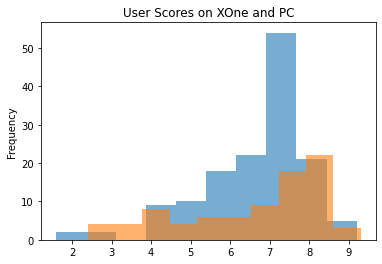

The variance of user scores on XOne = 1.85
The variance of user scores on PC = 3.01


In [60]:
alpha = .05 # critical statistical significance level, if the p-value is less than alpha, we reject the hypothesis
df_xone = df.query('platform == "XOne"')
df_pc= df.query('platform == "PC"')
                
df_xone['user_score'].plot(kind="hist",alpha=0.6)
df_pc['user_score'].plot(kind="hist",alpha=0.6)
plt.title("User Scores on XOne and PC")
plt.show()
print("The variance of user scores on XOne = {:.2f}".format(np.var(df_xone['user_score'])))
print("The variance of user scores on PC = {:.2f}".format(np.var(df_pc['user_score'])))

In [61]:
# Calculate the p-value with equal_val as False
# The variances of the statistical populations from which the samples are approximately the same
results = st.ttest_ind(
        df_xone['user_score'], 
        df_pc['user_score'],
        equal_var = True)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  0.3541893880863479
We can't reject the null hypothesis


This indicates that there is no statistically significant difference between user scores between XOne and PC. Choosing an alpha of 1% would not have made a difference in the result of the hypothesis test.

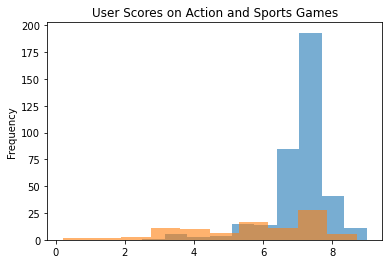

The variance of user scores on Action titles = 0.75
The variance of user scores on Sports titles = 3.72


In [62]:
df_action = df.query('genre == "Action"')
df_sports = df.query('genre == "Sports"')
                
df_action['user_score'].plot(kind="hist",alpha=0.6)
df_sports['user_score'].plot(kind="hist",alpha=0.6)
plt.title("User Scores on Action and Sports Games")
plt.show()
print("The variance of user scores on Action titles = {:.2f}".format(np.var(df_action['user_score'])))
print("The variance of user scores on Sports titles = {:.2f}".format(np.var(df_sports['user_score'])))

In [63]:
# Calculate the p-value with equal_val as False
# The variances of the statistical populations from which the samples are different
results = st.ttest_ind(
        df_action['user_score'], 
        df_sports['user_score'],
        equal_var = False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  4.1218168402351445e-11
We reject the null hypothesis


This indicates that there is a statistically significant difference between user scores between Action and Sports titles. Choosing an alpha of 1% would not have made a difference in the result of the hypothesis test.

By the result of the first hypothesis we see that users scores between platforms is approximately the same. People get the same level of joy, no matter which platform they play the games on. It makes sense that the minor differences in technology shouldn't effect the entertainment/experience.

By the result of the second hypothesis we see that there is a significant difference between user's opinons of action and sports games. The enjoyment level of different types of games will be largely subjective to the gamer. 

## Step 6. Conclusion

There are clear differences in how various platforms and genres sell and are scored by users and critics. This difference can be seen in individual distributions as well as between the world regions. 

While there were many missing values in the scores, most could be approximated with related medians and the rest weren't relevant to analysis. 

The sales throughout the year showed that sales hit a strong peak but have entered a decline. Our data also showed a clear lifecycle of platforms where new companys' products fill the void of the old platform's decline. 

In the region profiles we saw clear differences between the users' tastes in genre. 

In our hypothesis we saw that user's between platforms will get the same enjoyment but not on different types of games. It's clear the the Sony platforms sell the best and gamers aren't shy about violence- they love action and shooter games.